# Red Wine Quality
[Dataset Link](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009)

# Introduction
Let's assume a role of a Specification Manager for a brand new winery. Your task is to identify wine properties which are the most impactful in separating regular wines from good quality wines. Using the dataset, you will pick out the most influential properties and try to create a model to see how well your assumptions perform on the dataset.

## Context
The study will analyze the wine quality data and identify which wine properties are key predictors to wine quality. Finally, using these properties, the study will develop a statistical model to predict wine quality ratings.
1. Explore the data - distributions, correlations & significance of IV-DV relationships.
2. Feature selection - identify key wine properties for statistical modeling.
3. Statistical model - create a regression model to predict wine quality.

## Summary
The study found the following:
1. Majority of data is not normally distributed, including wine quality.
2. Several wine properties contain stark outliers.
3. The following features were selected for predicting wine quality:
    * `volatile_acidity`
    * `citric_acid`
    * `chlorides`
    * `total_sulfur_dioxide`
    * `pH`
    * `sulphates`
    * `alcohol`
4. A Random Forest model with Grid Search was used to predict the wine quality. 

# Data Preparation
## Imports & Configuration

In [1]:
# Core Modules, Helper Functions
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split

from utils import random_forest, ordinal_logistic_regression, get_model_results
from utils import visualize_performance, calculate_weights, two_sample_t_test

In [2]:
# Suppress warnings
warnings.filterwarnings("ignore", message="Precision loss occurred in moment calculation due to catastrophic cancellation")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Charts' Color Palette
color_palette = sns.color_palette("colorblind")
sns.set_style("whitegrid", {'axes.grid' : False})

In [4]:
df = pd.read_csv('data/winequality-red.csv')

## Data Formatting & Cleaning
Replace spaces in column names with underscores.

In [5]:
df.columns = df.columns.str.replace(' ', '_')

Check the columns' datatypes.

In [6]:
print("DataFrame data types:")
df.dtypes

DataFrame data types:


fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
residual_sugar          float64
chlorides               float64
free_sulfur_dioxide     float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

Check for missing values.

In [7]:
missing_rows_count = df.isnull().any(axis=1).sum()
print(f"Rows with missing values: {missing_rows_count}")

Rows with missing values: 0


Check for duplicate rows & remove them.

In [8]:
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 240


In [9]:
df.drop_duplicates(inplace=True)

Summarize the variables to get the picture of the distribution of data & check for outliers.

In [10]:
df.describe().round(2)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1359.00,1359.00,1359.00,1359.00,1359.00,1359.00,1359.00,1359.00,1359.00,1359.00,1359.00,1359.00
mean,8.31,0.53,0.27,2.52,0.09,15.89,46.83,1.00,3.31,0.66,10.43,5.62
std,1.74,0.18,0.20,1.35,0.05,10.45,33.41,0.00,0.16,0.17,1.08,0.82
min,4.60,0.12,0.00,0.90,0.01,1.00,6.00,0.99,2.74,0.33,8.40,3.00
25%,7.10,0.39,0.09,1.90,0.07,7.00,22.00,1.00,3.21,0.55,9.50,5.00
50%,7.90,0.52,0.26,2.20,0.08,14.00,38.00,1.00,3.31,0.62,10.20,6.00
75%,9.20,0.64,0.43,2.60,0.09,21.00,63.00,1.00,3.40,0.73,11.10,6.00
max,15.90,1.58,1.00,15.50,0.61,72.00,289.00,1.00,4.01,2.00,14.90,8.00


Key observations:
* The wine `quality` ranges **from 3 to 8 points**. The mean is 5.62, indicating that most wines are of average quality.
* `residual_sugar`has a wide value range of [0.90; 15.50], with a mean of 2.52; This wide range, combined with a standard deviation of 1.35, indicates that most wines have low residual sugar quantities, while a few have significantly higher values.
* `alcohol` has values mostly close to the mean, as shown by the standard deviation and the relatively narrower variability of values between the wines.
* `density` and `pH` are mostly consistent throughout all wines, based on the standard deviations. 


# Exploratory Data Analysis

## Quality distribution
### Histogram & Q-Q plot
Let's observe the distribution of `quality` visually with a histogram and a Q-Q plot to see if the ratings are normally distributed.

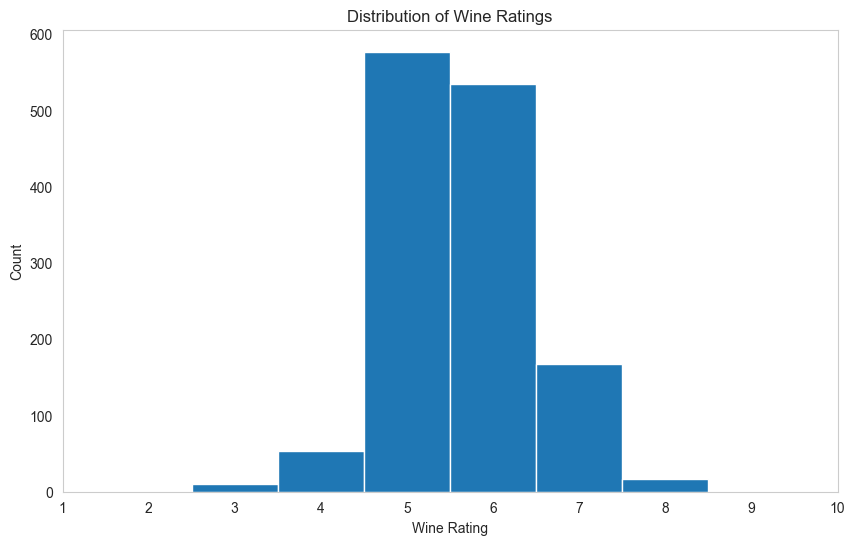

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(df['quality'], bins=np.arange(min(df['quality']), max(df['quality'])+2) - 0.5)
plt.xticks(range(1, 11))
plt.xlabel('Wine Rating')
plt.ylabel('Count')
plt.title('Distribution of Wine Ratings')
plt.show()

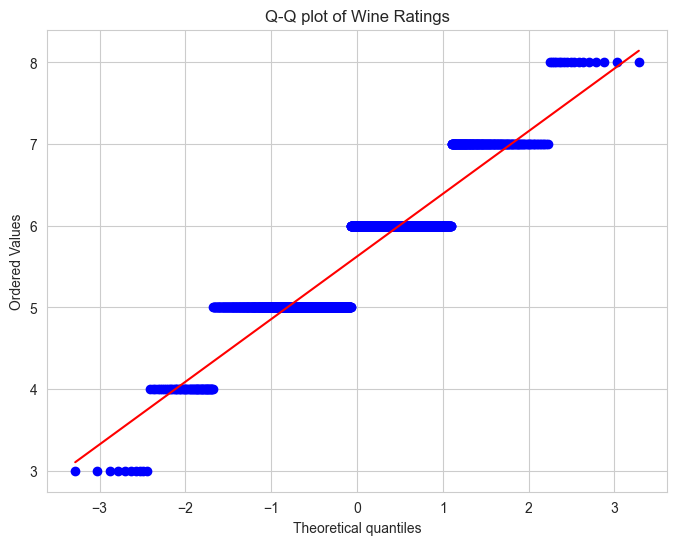

In [12]:
plt.figure(figsize=(8, 6))
stats.probplot(df['quality'], dist="norm", plot=plt)
plt.title('Q-Q plot of Wine Ratings')
plt.grid(True)
plt.show()

### Shapiro-Wilk Test
The Shapiro-Wilk test statistic is a measure of how closely the data follows a normal distribution
* The closer the Test statistic is to 1, the more likely it is that the data follows a normal distribution.
* If the p-value is larger than a chosen significance level (e.g. 0.05), there is evidence that the data follows a normal distribution.

In [13]:
shapiro_test = stats.shapiro(df['quality'])
print("Shapiro-Wilk Test:")
print("Test Statistic:", round(shapiro_test.statistic, 4))
print("p-value:", shapiro_test.pvalue)
print("Number of rows:", len(df))

Shapiro-Wilk Test:
Test Statistic: 0.864
p-value: 9.412484381244286e-33
Number of rows: 1359


The Test Statistic is not very close to 1. Furthermore, the p-value is extremely small. Both results indicate that the quality rating is not entirely normally distributed. Regardless, a sample size of 1359 rows should be sufficient to offset this deviation from normality and perform inferential tests.

## Distribution of Data
Let's review the distribution of IVs within the dataset.
* Assess distribution
* Check for outliers

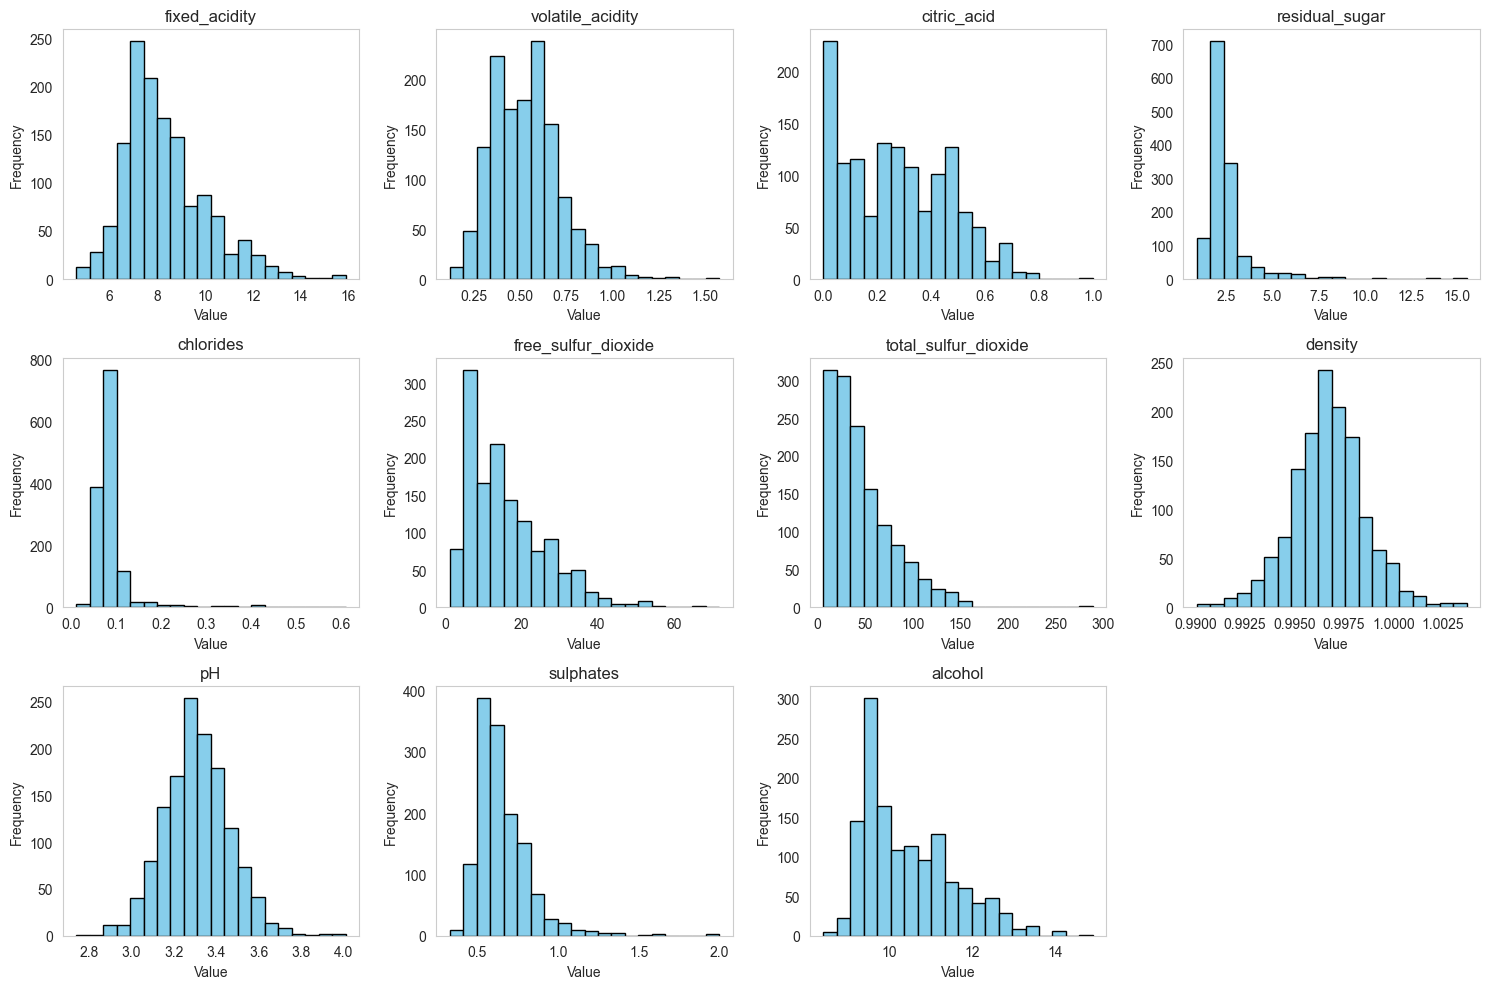

In [14]:
X = df.drop('quality', axis=1)

rows, cols = 3, 4
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10))

axes = axes.flatten()
for i, col in enumerate(X.columns):
    axes[i].hist(X[col], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    
for j in range(i+1, rows*cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**Bell-shaped**:
* Density
* pH

**Bimodal**:
* Volatile acidity
* Citric acid

**Right-skewed**:
* Fixed acidity
* Residual sugar
* Chlorides
* Free sulfur dioxide
* Total sulfur dioxide
* Sulphates
* Alcohol

Majority of wine properties have outliers. To get a better picture of outliers, let's visualize the distributions through boxplots.

## Wine Property Outliers

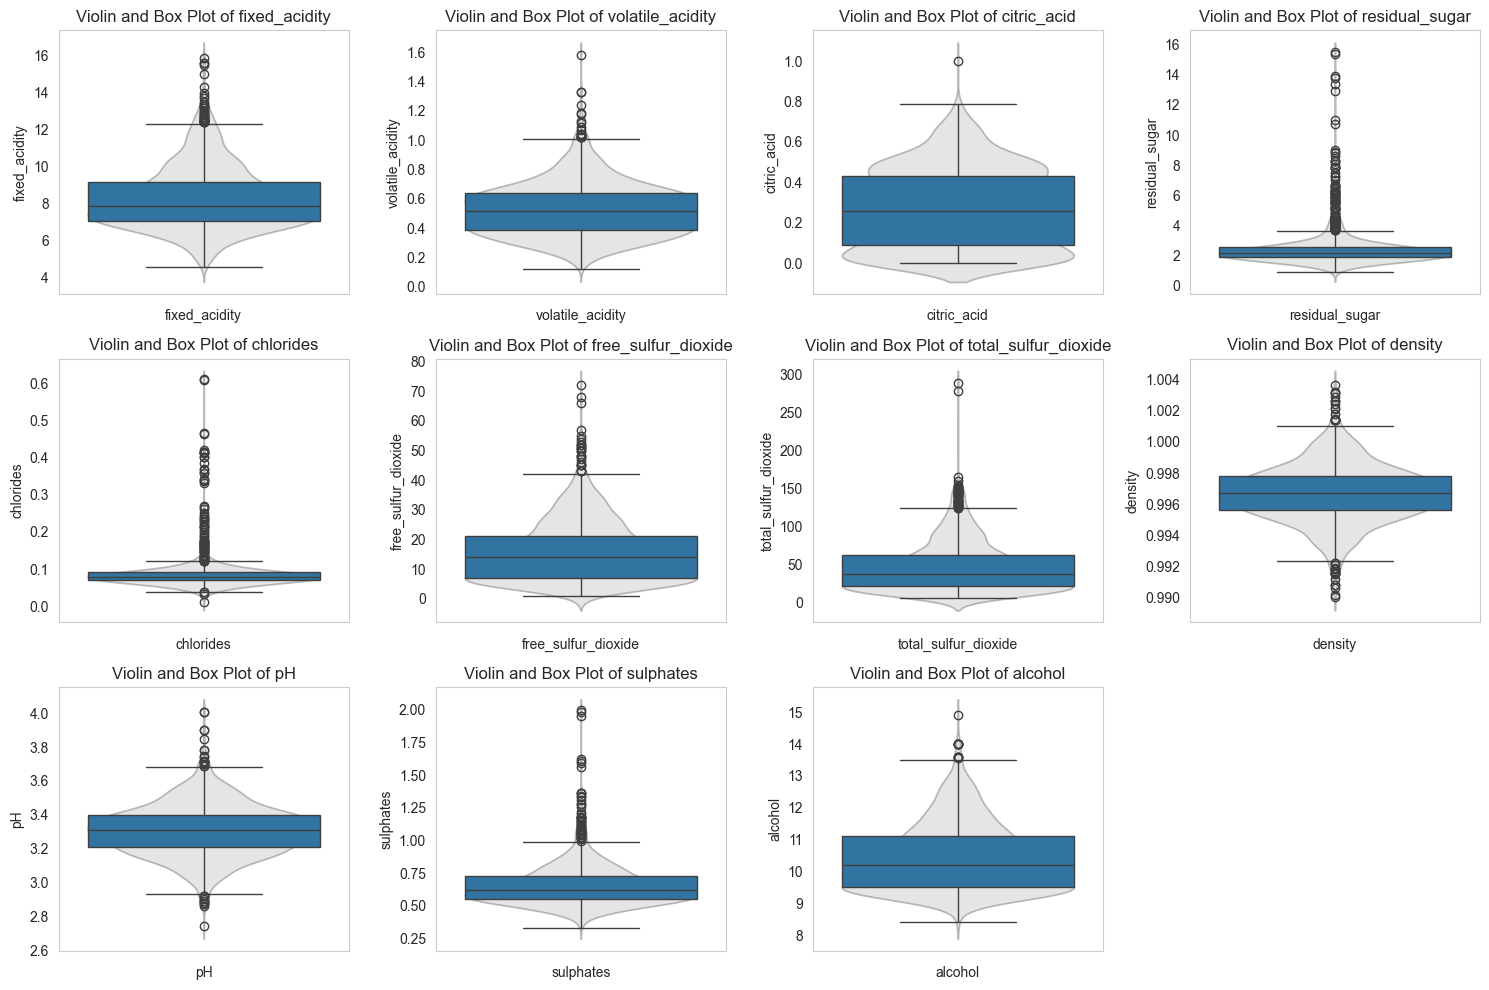

In [15]:
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10))

axes = axes.flatten()
for i, col in enumerate(X.columns):
    sns.violinplot(y=X[col], ax=axes[i], inner=None, color=".8", alpha=0.5)
    sns.boxplot(y=X[col], ax=axes[i], whis=1.5)
    axes[i].set_title(f'Violin and Box Plot of {col}')
    axes[i].set_xlabel(col)

for j in range(i+1, rows*cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Majority of properties have outliers, some of them have extreme. Due to the lack of domain expertise, it is reasonable to have a dataset with the outliers removed.

In [16]:
# Remove outliers
import seaborn as sns
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df_no_outliers = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
df_no_outliers.describe().round(2)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1005.00,1005.00,1005.00,1005.00,1005.00,1005.00,1005.00,1005.00,1005.00,1005.00,1005.00,1005.00
mean,8.17,0.52,0.25,2.20,0.08,14.97,42.50,1.00,3.32,0.63,10.37,5.62
std,1.47,0.17,0.18,0.45,0.01,8.81,26.66,0.00,0.13,0.11,0.98,0.73
min,5.10,0.12,0.00,1.20,0.04,1.00,6.00,0.99,2.94,0.33,8.70,4.00
25%,7.10,0.39,0.08,1.90,0.07,8.00,22.00,1.00,3.23,0.55,9.50,5.00
50%,7.80,0.52,0.24,2.10,0.08,13.00,36.00,1.00,3.32,0.61,10.10,6.00
75%,9.00,0.63,0.40,2.50,0.09,20.00,56.00,1.00,3.40,0.70,11.00,6.00
max,12.30,1.01,0.73,3.65,0.12,42.00,124.00,1.00,3.68,0.98,13.40,7.00


Interestingly, removing the outliers caused the best-rated wines to disappear! Since we need those, we will continue performing analysis with all data present, but in the modeling we will **assign class weights**, or, if the performance is poor, model without outliers and then assign the class weights.

## Correlation of variables
To develop hypotheses for inference testing & select features for the model, let's first look at the correlations between variables.

### Correlation Matrix

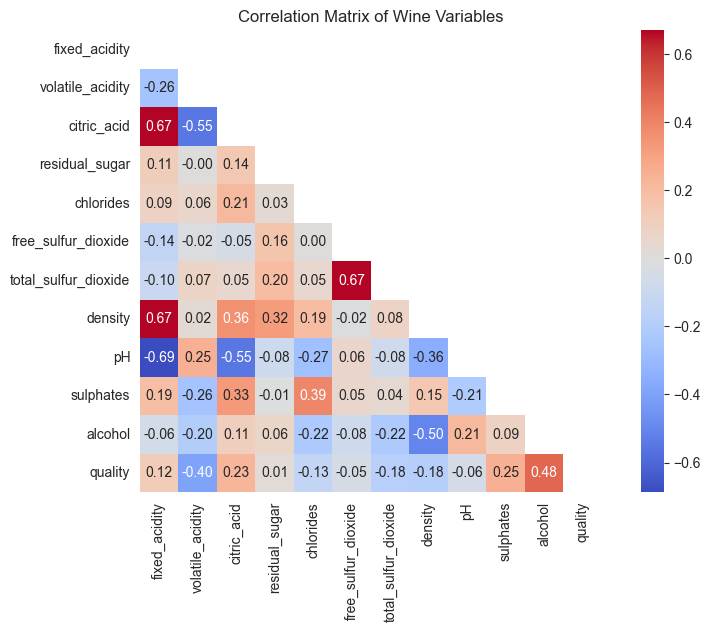

In [17]:
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, mask=mask)
plt.title('Correlation Matrix of Wine Variables')
plt.show()

Biggest **positive** correlations:
* Citric acid - Fixed acidity
* Density - Fixed acidity
* Total Sulfur Dioxide - Free Sulfur Dioxide

Biggest **negative** correlations:
* Fixed Acidity - pH
* Citric acid - Volatile acidity
* Citric acid - pH
* Density - alcohol

`alcohol` and `sulphates` seem to have the biggest **positive correlation** to the wine quality rating. The two IVs have only a minor positive correlation; multicollinearity might not be a problem.

`volatile_acidity` seems to have the biggest **negative correlation** to wine quality.

### Alcohol, Sulphates and Volatile acidity for Wine Quality
Let's draw three visuals showing the distribution of alcohol, sulphates and volatile acidity for each quality rating.

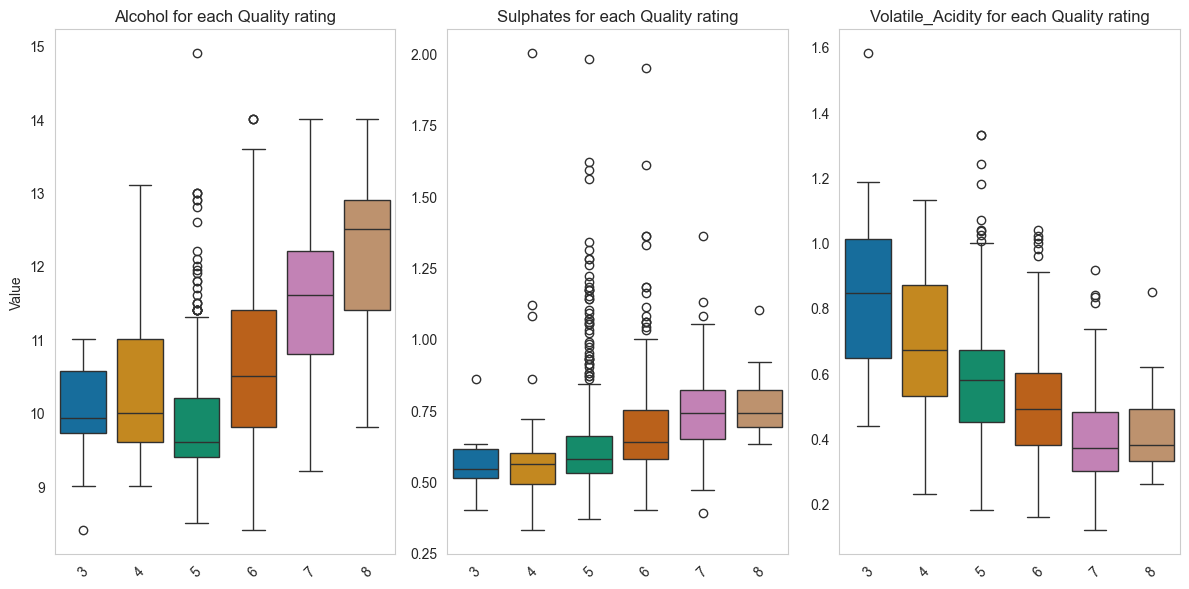

In [18]:
vars = ['alcohol', 'sulphates', 'volatile_acidity']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
for i, var in enumerate(vars):
    sns.boxplot(x='quality', y=var, data=df, ax=axes[i], palette=color_palette)
    axes[i].set_title(f'{var.title()} for each Quality rating')
    axes[i].set_ylabel('')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)
axes[0].set_ylabel('Value')
plt.tight_layout()
plt.show()

Observations:
* Wines with **more alcohol** tend to have a higher rating.
* Wines with **less volatile acidity** tend to have a higher rating.
* We have a lot of outliers in the 5 rating category.

#### T-Tests
The purpose of the following t-tests is to test whether our visual observations are correct - that the shift in these three variables has a significant impact to wine quality.

Let's perform a two-sample t-test to check the assuption that wines with higher alcohol content have a higher quality rating.

**Question**: Is wine quality rating higher for wines with a higher alcohol content?
* *Null Hypothesis (H0)*: There is no difference in average ratings between low and high alcohol contents.
* *Alternative Hypothesis (H1)*: Higher alcohol content wines have a higher rating on average.

We'll assume a threshold of the alcohol mean for differentiation of the two groups.

In [19]:
wine_alcohol = df[['alcohol', 'quality']]
two_sample_t_test(wine_alcohol, 'alcohol', 'quality')

t-statistic: 16.792420
p-value: 0.000000


The extremely small p-value indicates that there is a difference in quality ratings between high and low alcohol wines.
Let's also perform a t-test on the statistical significance of sulphates.

**Question**: Is wine quality rating higher for wines with higher sulphates contents?
* *Null Hypothesis (H0)*: There is no difference in average ratings between normal and higher sulphate content wines.
* *Alternative Hypothesis (H1)*: Higher sulphate concentration wines have a higher rating on average.

We'll assume a threshold of the sulphate mean for differentiation of the two groups. 

In [20]:
wine_sulphates = df[['sulphates', 'quality']]
two_sample_t_test(wine_sulphates, 'sulphates', 'quality')

t-statistic: 13.753190
p-value: 0.000000


Finally, let's perform a t-test on the statistical significance of volatile acidity.

**Question**: Is wine quality rating higher for wines with a lower volatile acidity?
* *Null Hypothesis (H0)*: There is no difference in average ratings between normal and lower volatile acidity wines.
* *Alternative Hypothesis (H1)*: Lower volatile acidity wines have a higher rating on average.

We'll assume a threshold of the volatile acidity mean for differentiation of the two groups. 

In [21]:
wine_acidity = df[['volatile_acidity', 'quality']]
two_sample_t_test(wine_acidity, 'volatile_acidity', 'quality')

t-statistic: -12.153283
p-value: 0.000000


In all three cases, the p-value is extremely small. This indicates that we should definitely consider adding `alcohol`, `sulphates` and `volatile_acidity` to the feature list of our model.

## The highly-rated wines

As noted previously, after removing the outliers, the best-rated wines disappeared. Let's explore the difference in features between the 8-rating wines and the dataset with outliers removed. This might help us find meaningful features besides `alcohol`, `sulphates` and `volatile_acidity` that determine a high wine rating.

In [22]:
best_rated = df[df['quality'] == 8].drop(['quality'], axis=1)
other_wines = df_no_outliers.drop(['quality'], axis=1)

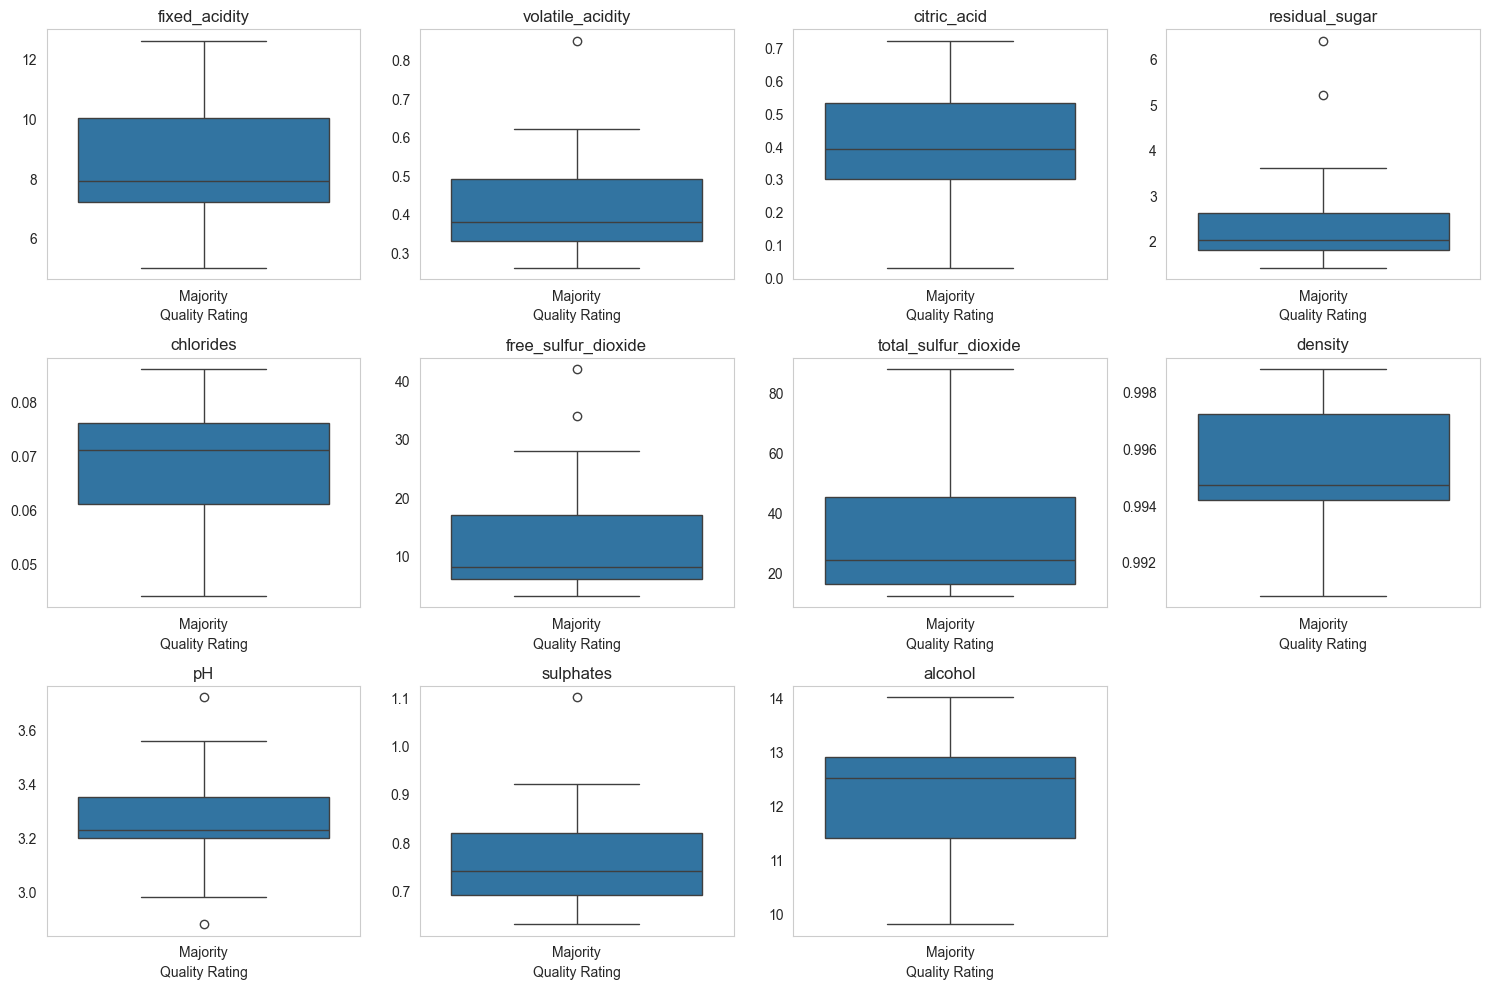

In [23]:
independent_vars = df.drop(['quality'], axis=1).columns.to_list()

# Figure and axis
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
ax = ax.flatten()
for i, var in enumerate(independent_vars):
    sns.boxplot(data=[other_wines[var], best_rated[var]], ax=ax[i], orient='v')
    ax[i].set_title(var)
    ax[i].set_xlabel('Quality Rating')
    ax[i].set_xticklabels(['Majority', 'Best-rated'])

# Hide empty subplots
for j in range(i+1, 12):
    ax[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

Observations:
* `alcohol` and `sulphates` contents are generally higher for best-rated wines, which supports our hypothesis tests.
* `volatile_acidity` is lower for best-rated wines, also supporting the hypothesis test.
* `fixed_acidity` tends to be higher for better-rated wines.
* Both `free_sulfur_dioxide` and `total_sulfur_dioxide` are lower for high-rated wines. Since both of these IVs are positively correlated, we will pick `total_sulfur_dioxide` as it has a higher correlation to `quality` as per the correlation matrix.

## Wine Properties visualization using BI Tools
[Link](https://public.tableau.com/app/profile/pijus.jur.iukonis/viz/RedWineProperties/Dashboard1)

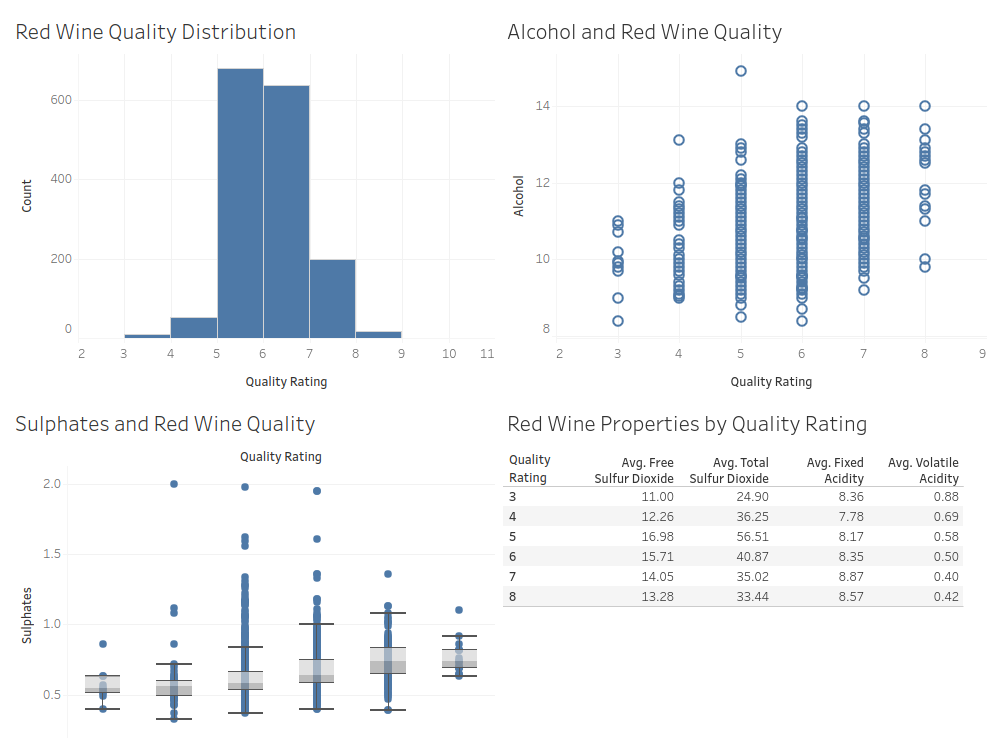

In [24]:
Image(filename='./media/wine_properties_dashboard.png')

# Modeling
Let's build a linear regression model to quantify the impacts of independent variables to wine quality.
1. Perform feature selection
2. Build the model, fit data
3. Test the model against testing data

## Feature Selection
We will standardize the data and choose the features; Since the best-rated wines are outliers, and we want to discover the formula to creating high-rated wines, we will perform feature selection using all the data.
For feature selection, we will use **the LASSO method.**

In [25]:
X = df.drop('quality', axis=1)
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso = LassoCV(cv=5, random_state=42).fit(X_train_scaled, y_train)
coefficients = lasso.coef_[(lasso.coef_ != 0)]
selected_features = X.columns[(lasso.coef_ != 0)]
print("Selected Features and their Coefficients:")
for feature, coef in zip(selected_features, coefficients):
    print(f"{feature}: {coef:.4f}")

Selected Features and their Coefficients:
volatile_acidity: -0.1764
residual_sugar: -0.0071
chlorides: -0.0802
free_sulfur_dioxide: 0.0426
total_sulfur_dioxide: -0.0976
pH: -0.0808
sulphates: 0.1469
alcohol: 0.3023


`alcohol`, `sulphates` and `volatile_acidity` made the list, which means that our statistical significance tests were correct.
`fixed_acidity` didn't make the list, as it must've been statistically insignificant in the entirety of the dataset. Regardless, we will perform a separate test with it included.
`free_sulfur_dioxide` will be removed as it largely correlates with `total_sulfur_dioxide`, and the latter has higher correlation to quality.

## Statistical Models
As we have previously observed, the `quality` variable is not entirely normally distributed. With that in mind, the following statistical models will be used:
* **Ordinal Logistic Regression** - does not require the DV to be normally distributed & suitable for ordinal data.
* **Random Forest** - can transform the ordinal DV into a categorical variable, does not require DV to be normally distributed & can capture non-linear relationships between the DV and the IVs.

We will test the models with the **entirety of the dataset**.

In [26]:
# IVs and DV
independent_vars = ['volatile_acidity', 'citric_acid', 'chlorides', 'total_sulfur_dioxide', 'pH', 'sulphates', 'alcohol']
X = df[independent_vars]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Ordinal Logistic Regression

Ordinal Logistic regression results
R-squared: -0.9774457610624534
Mean squared error: 1.400735294117647
Mean absolute error: 0.8125


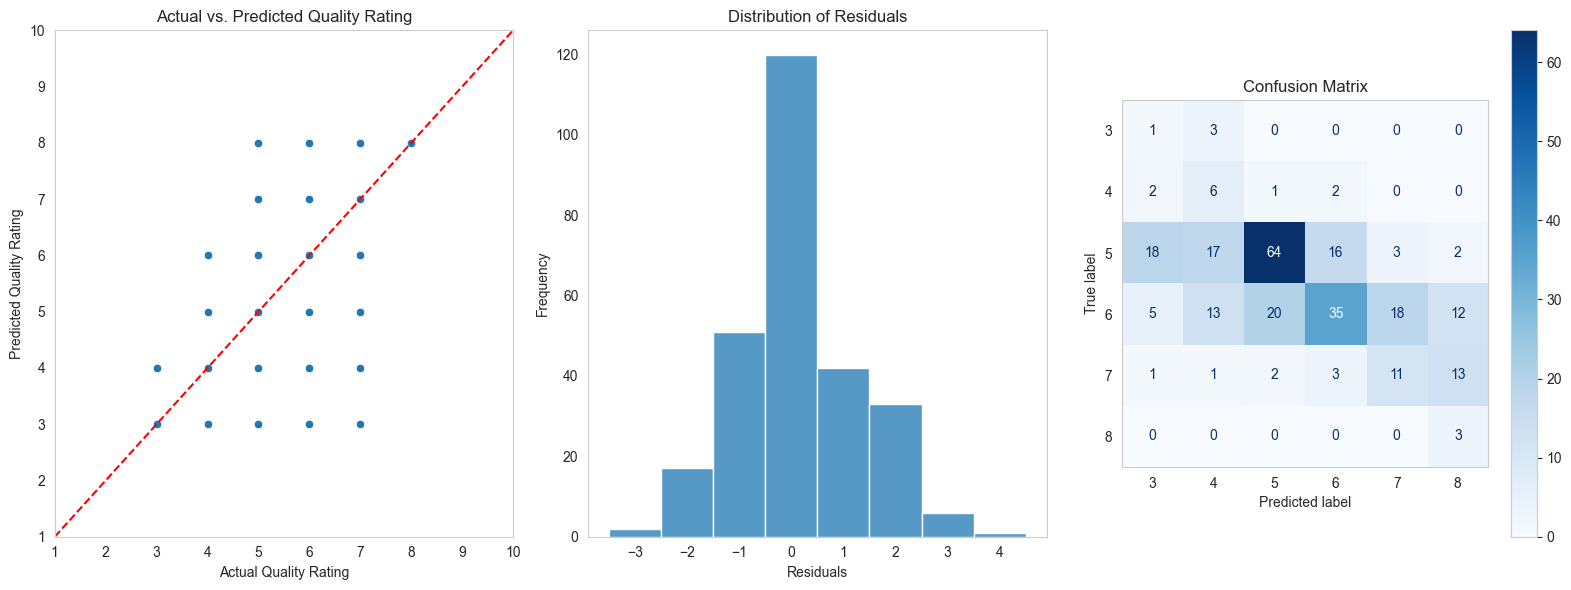

In [28]:
class_weights_dict = calculate_weights(y_train)
y_pred_ord = ordinal_logistic_regression(X_train, y_train, X_test, class_weights_dict)
print("Ordinal Logistic regression results")
get_model_results(y_test, y_pred_ord)
visualize_performance(y_test, y_pred_ord)

### Random Forest
The Random Forest model will use Grid Search to improve performance of the model further.

                Feature  Importance
6               alcohol    0.173454
2             chlorides    0.158608
5             sulphates    0.149634
0      volatile_acidity    0.149621
3  total_sulfur_dioxide    0.131240
4                    pH    0.119830
1           citric_acid    0.117613
Random Forest results
R-squared: 0.3408514129791822
Mean squared error: 0.46691176470588236
Mean absolute error: 0.3786764705882353


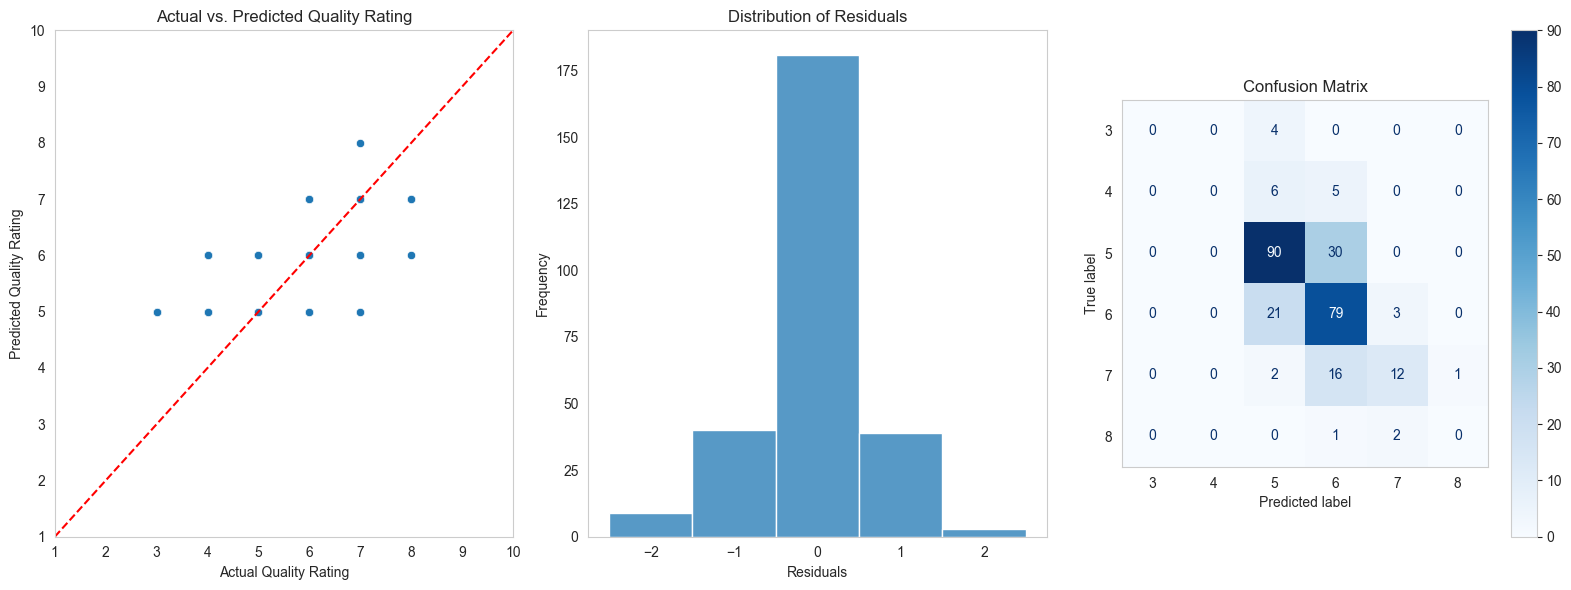

In [29]:
class_weights_dict = calculate_weights(y_train)
y_pred_ord = random_forest(X_train, y_train, X_test, class_weights_dict)
print("Random Forest results")
get_model_results(y_test, y_pred_ord)
visualize_performance(y_test, y_pred_ord)

# Summary
## Findings
The Ordinal Logistic Regression model did not work that well; the model is performing worse than a horizontal line (mean of the target values). The Random Forest performed better.

Random Forest results:
Moderate R-squared performance, moderate mean and absolute errors.

Visualizations:

The points are somewhat scattered around the line, indicating some prediction error, but they do show **a general trend along the line**, suggesting the model captures the overall pattern.

The histogram of residuals shows that most residuals are centered around 0.
The distribution is slightly skewed, indicating that the model has some prediction bias, but overall, the residuals are reasonably well distributed.

The matrix shows that the model predicts classes 5 and 6 reasonably well but struggles with some misclassifications between these and other classes. More often than not, if it made a mistake in prediction, it predicted a better rating.

Ultimately, the model does not have many extreme missclassifications, and should classify the wine close to it's true rating.

## Considerations
* Size of the dataset (less than 2000 wines).
* Calculation logic of wine quality.
* Distribution of normal and great/bad wines.
* Recency of the data (2009)

## Improvements for Future Studies
* Consider a statistical model that categorizes the wines (good/bad quality).
* Perform an expanded grid search with additional hyperparameters for better model accuracy (bootstrap, n_estimators, etc.).
* Consider other models, like GBM.
